In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import surprise

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

In [3]:
%matplotlib inline

In [4]:
plt.rcParams["figure.figsize"] = (8, 6)

# Read Data

In [55]:
#Reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,encoding='latin-1')

#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,encoding='latin-1')

#Reading items file:
i_cols = ['movie_id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols,
encoding='latin-1')

In [6]:
users.to_csv('users.csv', index=False)

In [7]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
items.head()

,movie_id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [58]:
items[['movie_id', 'movie title', 'release date', 'IMDb URL']].to_csv('movies.csv', index=False)

# Exploration Data Analysis

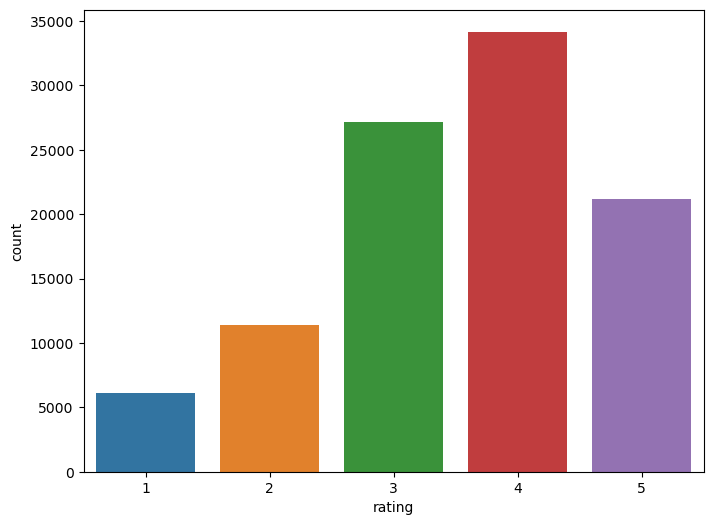

In [9]:
# Rating distribution
sns.countplot(data=ratings, x="rating");

In [10]:
print(users.shape)
print(items.shape)
print(ratings.shape)

(943, 5)
(1682, 24)
(100000, 4)


In [11]:
print("Unique Users:\t", ratings.user_id.nunique())
print("Unique Movies:\t", ratings.movie_id.nunique())

Unique Users:	 943
Unique Movies:	 1682


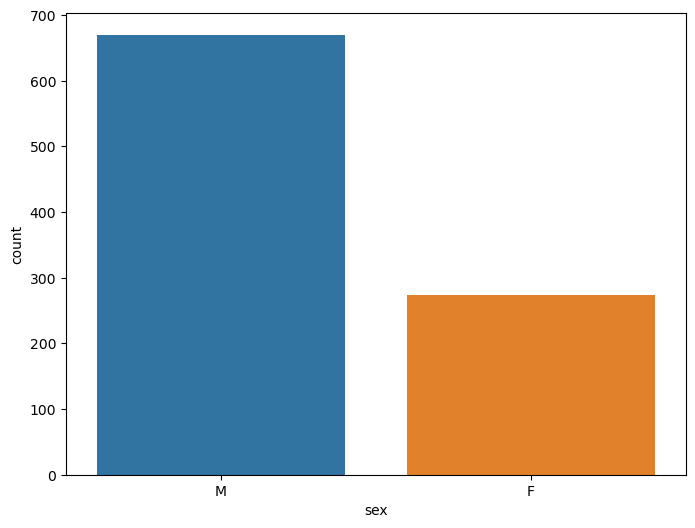

In [12]:
# Sex distribution
sns.countplot(data=users, x="sex");

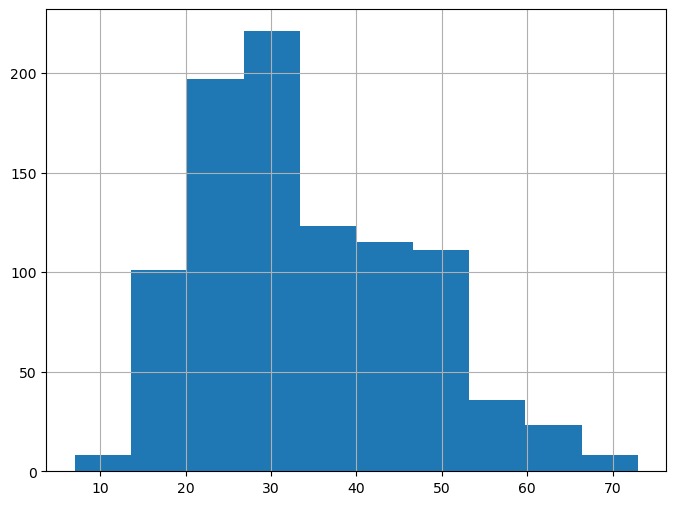

In [13]:
# Age distribution
users.age.hist();

# Surprise

In [14]:
import surprise

In [134]:
reader = surprise.Reader()
dataset = surprise.Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)
train_dataset = dataset.build_full_trainset()
valid_dataset = train_dataset.build_testset()
test_dataset = train_dataset.build_anti_testset()

# Models

## Matrix Factorization

In [57]:
param_grid = {
    'n_factors': [12, 13, 14, 15, 16, 17, 18], 
    'n_epochs': [12, 13, 14, 15, 16, 17, 18], 
    'lr_all': [0.015, 0.02, 0.025], 
    'reg_all': [0.08, 0.09, 0.1]
    }

In [58]:
grid_search_svd = surprise.model_selection.GridSearchCV(
    surprise.SVD, 
    param_grid, 
    measures=['rmse', 'mae'], 
    cv=5,
    n_jobs=-1
    )
grid_search_svd.fit(dataset)

In [59]:
best_svd = grid_search_svd.best_estimator['rmse']
print("Best score:\t", grid_search_svd.best_score['rmse'])
print("Best params:\t", grid_search_svd.best_params['rmse'])

Best score:	 0.9149025163866229
Best params:	 {'n_factors': 18, 'n_epochs': 18, 'lr_all': 0.02, 'reg_all': 0.09}


In [63]:
param_grid = {
    'n_factors': list(range(10, 15)), 
    'n_epochs': list(range(15, 31, 3))
    }

In [64]:
grid_search_svdpp = surprise.model_selection.GridSearchCV(
    surprise.SVDpp, 
    param_grid, 
    measures=['rmse', 'mae'], 
    cv=5,
    n_jobs=-1
    )
grid_search_svdpp.fit(dataset)

In [65]:
best_svdpp = grid_search_svdpp.best_estimator['rmse']
print(grid_search_svdpp.best_score['rmse'])
print(grid_search_svdpp.best_params['rmse'])

0.9171271338508152
{'n_factors': 13, 'n_epochs': 18}


In [78]:
param_grid = {
    'n_factors': [140, 150, 160], 
    'n_epochs': [100, 110, 120, 130, 140]
    }

In [79]:
grid_search_nmf = surprise.model_selection.GridSearchCV(
    surprise.NMF, 
    param_grid, 
    measures=['rmse', 'mae'], 
    cv=5,
    n_jobs=-1
    )
grid_search_nmf.fit(dataset)

In [94]:
best_nmf = grid_search_nmf.best_estimator['rmse']

In [80]:
print("Best score NMF:\t", grid_search_nmf.best_score['rmse'])
print("Best params NMF:\t", grid_search_nmf.best_params['rmse'])

Best score NMF:	 0.9167715498691255
Best params NMF:	 {'n_factors': 150, 'n_epochs': 120}


# KNNS

In [12]:
param_grid = {
    'k': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
    'sim_options': {
        'name': ['cosine', 'pearson_baseline'],
        'user_based': [False]
        },
    'bsl_options': {
        'method': ['als', 'sgd']
        }
    }

grid_search_knnbaseline_ib = surprise.model_selection.GridSearchCV(
    surprise.KNNBaseline, 
    param_grid, 
    measures=['rmse', 'mae'], 
    cv=5,
    n_jobs=-1
    )

grid_search_knnbaseline_ib.fit(dataset)
print(grid_search_knnbaseline_ib.best_score['rmse'])
print(grid_search_knnbaseline_ib.best_params['rmse'])

Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using sgd...
Estimating biases using sgd...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Estimating biases using sgd...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using als...
Computing the cosine similarity matrix...
Computing

In [13]:
param_grid = {
    'k': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
    'sim_options': {
        'name': ['cosine', 'pearson_baseline'],
        'user_based': [True]
        },
    'bsl_options': {
        'method': ['als', 'sgd']
        }
    }

grid_search_knnbaseline_us = surprise.model_selection.GridSearchCV(
    surprise.KNNBaseline, 
    param_grid, 
    measures=['rmse', 'mae'], 
    cv=5,
    n_jobs=-1
    )

grid_search_knnbaseline_us.fit(dataset)
print(grid_search_knnbaseline_us.best_score['rmse'])
print(grid_search_knnbaseline_us.best_params['rmse'])

Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using sgd...
Estimating biases using sgd...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix..

In [89]:
best_knnbaseline_us = grid_search_knnbaseline_us.best_estimator['rmse']
best_knnbaseline_ib = grid_search_knnbaseline_ib.best_estimator['rmse']

## CoClustering

In [90]:
param_grid = {
    'n_cltr_u': list(range(15, 20, 1)),
    'n_cltr_i': list(range(1, 5, 1)),
    'n_epochs': list(range(40, 60))
    }

grid_search_coclustering = surprise.model_selection.GridSearchCV(
    surprise.CoClustering, 
    param_grid, 
    measures=['rmse', 'mae'], 
    cv=5,
    n_jobs=-1
    )

grid_search_coclustering.fit(dataset)
print(grid_search_coclustering.best_score['rmse'])
print(grid_search_coclustering.best_params['rmse'])

0.948190566101173
{'n_cltr_u': 18, 'n_cltr_i': 2, 'n_epochs': 55}


In [91]:
best_coclustering = grid_search_coclustering.best_estimator['rmse']

# Best Models

Best models:

SVD = {
    'n_factors': 18, 'n_epochs': 18, 'lr_all': 0.02, 'reg_all': 0.09
}

SVDpp = {
    'n_factors': 13, 'n_epochs': 18
}

NMF = {
    'n_factors': 150, 'n_epochs': 120
}

KNNS user based = {
    'k': 50, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'bsl_options': {'method': 'sgd'}
}

KNNS item based = {
    'k': 40, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'bsl_options': {'method': 'sgd'}
}

CoClustering = {
    'n_cltr_u': 18, 'n_cltr_i': 2, 'n_epochs': 55
}

In [170]:
svd = surprise.SVD(
    n_factors=18,
    n_epochs=18,
    lr_all=0.02,
    reg_all=0.09
)

In [171]:
svdpp = surprise.SVDpp(
    n_factors=13,
    n_epochs=18
)

In [172]:
nmf = surprise.NMF(
    n_factors=150,
    n_epochs=120
)

In [173]:
knn_ub = surprise.KNNBaseline(
    k=50, 
    sim_options={ 
        'name': 'pearson_baseline', 
        'user_based': True
        }, 
    bsl_options={
        'method': 'sgd'
        }
)

In [174]:
knn_ib = surprise.KNNBaseline(
    k=40, 
    sim_options={ 
        'name': 'pearson_baseline', 
        'user_based': False
        }, 
    bsl_options={
        'method': 'sgd'
        }
)

In [175]:
coclustering = surprise.CoClustering(
    n_cltr_u=18, 
    n_cltr_i=2, 
    n_epochs=55
)

In [176]:
slopeOne = surprise.SlopeOne()

# Predict

In [177]:
models = [svd, svdpp, nmf, knn_ub, knn_ib, coclustering, slopeOne]
train = ratings[['user_id', 'movie_id', 'rating']]
for i in range(7):
    predictions = models[i].fit(train_dataset).test(valid_dataset)
    model_pred = pd.DataFrame([[i.uid, i.iid, i.est] for i in predictions], columns=['user_id', 'movie_id', str(i)])
    train = pd.merge(train, model_pred, how='left', left_on=['user_id', 'movie_id'], right_on=['user_id', 'movie_id'])
train.columns = train.columns[:3].tolist() + ['svd', 'svdpp', 'nmf', 'knn_ub', 'knn_ib', 'coclustering', 'slopeOne']

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [178]:
train.head()

,user_id,movie_id,rating,svd,svdpp,nmf,knn_ub,knn_ib,coclustering,slopeOne
0,196,242,3,3.880662,3.951320,3.561629,3.403012,3.319512,3.969615,3.893535
1,186,302,3,3.708857,3.489682,3.227816,3.706521,3.213981,3.710777,4.358958
2,22,377,1,1.566972,1.529743,1.064641,1.299083,1.047155,1.752411,1.883408
3,244,51,2,3.161751,3.434587,3.039186,2.952629,2.609612,3.355053,3.581882
4,166,346,1,2.514560,3.305742,1.745623,2.173502,1.382996,2.818350,4.002400


In [187]:
data = np.array(np.meshgrid(np.unique(ratings.user_id), np.unique(ratings.movie_id))).T.reshape(-1, 2)
test = pd.DataFrame(data, columns=['user_id', 'movie_id'])

In [188]:
test.shape

(1586126, 2)

In [189]:
test = pd.concat([test, ratings[['user_id', 'movie_id']]]).drop_duplicates(keep=False)

In [191]:
test.shape

(1486126, 2)

In [192]:
models = [svd, svdpp, nmf, knn_ub, knn_ib, coclustering, slopeOne]
for i in range(7):
    predictions = models[i].fit(train_dataset).test(test_dataset)
    model_pred = pd.DataFrame([[i.uid, i.iid, i.est] for i in predictions], columns=['user_id', 'movie_id', str(i)])
    test = pd.merge(test, model_pred, how='left', left_on=['user_id', 'movie_id'], right_on=['user_id', 'movie_id'])
test.columns = test.columns[:2].tolist() + ['svd', 'svdpp', 'nmf', 'knn_ub', 'knn_ib', 'coclustering', 'slopeOne']

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [193]:
train.shape

(100000, 10)

In [195]:
train.head()

,user_id,movie_id,rating,svd,svdpp,nmf,knn_ub,knn_ib,coclustering,slopeOne
0,196,242,3,3.880662,3.951320,3.561629,3.403012,3.319512,3.969615,3.893535
1,186,302,3,3.708857,3.489682,3.227816,3.706521,3.213981,3.710777,4.358958
2,22,377,1,1.566972,1.529743,1.064641,1.299083,1.047155,1.752411,1.883408
3,244,51,2,3.161751,3.434587,3.039186,2.952629,2.609612,3.355053,3.581882
4,166,346,1,2.514560,3.305742,1.745623,2.173502,1.382996,2.818350,4.002400


In [194]:
test.shape

(1486126, 9)

In [196]:
test.head()

,user_id,movie_id,svd,svdpp,nmf,knn_ub,knn_ib,coclustering,slopeOne
0,1,273,3.624444,3.744074,3.870785,3.621630,3.851687,3.309828,3.632761
1,1,274,3.377291,3.300353,3.372349,3.415185,3.406694,3.240322,3.507211
2,1,275,4.116726,4.435748,4.138423,4.015166,4.069008,4.348580,4.065448
3,1,276,4.273201,3.891932,4.127626,4.249019,4.134701,4.035373,3.858593
4,1,277,3.813273,3.714715,3.709490,3.673514,3.941664,3.205110,3.622777


In [197]:
train.to_csv('train.csv', index=False)

In [198]:
test.to_csv('test.csv', index=False)

# Linear model

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train.head()

,user_id,movie_id,rating,svd,svdpp,nmf,knn_ub,knn_ib,coclustering,slopeOne
0,196,242,3,3.880662,3.951320,3.561629,3.403012,3.319512,3.969615,3.893535
1,186,302,3,3.708857,3.489682,3.227816,3.706521,3.213981,3.710777,4.358958
2,22,377,1,1.566972,1.529743,1.064641,1.299083,1.047155,1.752411,1.883408
3,244,51,2,3.161751,3.434587,3.039186,2.952629,2.609612,3.355053,3.581882
4,166,346,1,2.514560,3.305742,1.745623,2.173502,1.382996,2.818350,4.002400


In [7]:
test.head()

,user_id,movie_id,svd,svdpp,nmf,knn_ub,knn_ib,coclustering,slopeOne
0,1,273,3.624444,3.744074,3.870785,3.621630,3.851687,3.309828,3.632761
1,1,274,3.377291,3.300353,3.372349,3.415185,3.406694,3.240322,3.507211
2,1,275,4.116726,4.435748,4.138423,4.015166,4.069008,4.348580,4.065448
3,1,276,4.273201,3.891932,4.127626,4.249019,4.134701,4.035373,3.858593
4,1,277,3.813273,3.714715,3.709490,3.673514,3.941664,3.205110,3.622777


In [36]:
res = pd.read_csv('result.csv')

In [37]:
res.head()

,user_id,movie_id,svd,svdpp,nmf,knn_ub,knn_ib,coclustering,slopeOne,raiting
0,1,273,3.624444,3.744074,3.870785,3.621630,3.851687,3.309828,3.632761,3.732777
1,1,274,3.377291,3.300353,3.372349,3.415185,3.406694,3.240322,3.507211,3.369709
2,1,275,4.116726,4.435748,4.138423,4.015166,4.069008,4.348580,4.065448,3.878355
3,1,276,4.273201,3.891932,4.127626,4.249019,4.134701,4.035373,3.858593,4.282303
4,1,277,3.813273,3.714715,3.709490,3.673514,3.941664,3.205110,3.622777,3.937263


In [38]:
res = res.rename(columns={"raiting": "rating"})

In [39]:
res.shape

(1486126, 10)

In [40]:
res.head()

,user_id,movie_id,svd,svdpp,nmf,knn_ub,knn_ib,coclustering,slopeOne,rating
0,1,273,3.624444,3.744074,3.870785,3.621630,3.851687,3.309828,3.632761,3.732777
1,1,274,3.377291,3.300353,3.372349,3.415185,3.406694,3.240322,3.507211,3.369709
2,1,275,4.116726,4.435748,4.138423,4.015166,4.069008,4.348580,4.065448,3.878355
3,1,276,4.273201,3.891932,4.127626,4.249019,4.134701,4.035373,3.858593,4.282303
4,1,277,3.813273,3.714715,3.709490,3.673514,3.941664,3.205110,3.622777,3.937263


In [41]:
res['watched'] = np.zeros(len(res))

In [42]:
res['watched'] = res['watched'].astype(int)

In [48]:
res[['user_id', 'movie_id', 'rating', 'watched']].to_csv('not_watched.csv', index=False)

In [51]:
train['watched'] = np.ones(len(train))
train['watched'] = train['watched'].astype(int)

In [52]:
train[['user_id', 'movie_id', 'rating', 'watched']].to_csv('watched.csv', index=False)

In [53]:
train[['user_id', 'movie_id', 'rating', 'watched']]

,user_id,movie_id,rating,watched
0,196,242,3,1
1,186,302,3,1
2,22,377,1,1
3,244,51,2,1
4,166,346,1,1
...,...,...,...,...
99995,880,476,3,1
99996,716,204,5,1
99997,276,1090,1,1
99998,13,225,2,1


In [7]:
from sklearn.metrics import mean_squared_error

In [14]:
print("SVD:\t\t", mean_squared_error(train['svd'], train['rating'], squared=False))
print("SVDpp:\t\t", mean_squared_error(train['svdpp'], train['rating'], squared=False))
print("NMF:\t\t", mean_squared_error(train['nmf'], train['rating'], squared=False))
print("KNN user based:\t", mean_squared_error(train['knn_ub'], train['rating'], squared=False))
print("KNN item based:\t", mean_squared_error(train['knn_ib'], train['rating'], squared=False))
print("CoClustering:\t", mean_squared_error(train['coclustering'], train['rating'], squared=False))
print("SlopeOne:\t", mean_squared_error(train['slopeOne'], train['rating'], squared=False))

SVD:		 0.7992999736122793
SVDpp:		 0.8036363049084069
NMF:		 0.6070467320922356
KNN user based:	 0.48753848144478884
KNN item based:	 0.47817164870374657
CoClustering:	 0.9015966244444075
SlopeOne:	 0.8580831572042165


In [54]:
eNet = ElasticNet()

In [55]:
parameters = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "l1_ratio": np.arange(0.0, 1.0, 0.1)
    }

In [56]:
grid_search = GridSearchCV(
    eNet,
    param_grid=parameters,
    cv=5,
    n_jobs=-1
)

In [ ]:
grid_search.fit(train.iloc[:, 3:], train['rating'])

In [58]:
grid_search.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.0}

In [59]:
best_estimator = grid_search.best_estimator_

In [60]:
print("eNet:\t\t", mean_squared_error(best_estimator.predict(train.iloc[:, 3:]), train['rating'], squared=False))

eNet:		 0.2828028913863735


In [62]:
test['raiting'] = best_estimator.predict(test.iloc[:, 2:])

In [63]:
test.to_csv('result.csv', index=False)